# RQ 2.1 - 2.2: Filtering of Toxic Outputs and Attribution Scores
In these research subquestions, we do a lexical analysis of the tokens in prompts that cause toxic outputs. We will achieve this by performing the following steps:
1. Load all the toxic prompts.
2. Load all the results the LLM's generated based on the toxic prompts.
3. Filter to only keep the prompts and their results if the results are considered toxic. For this we use the threshold 0.8.
4. Then, every prompt is classified with a model that checks whether it is toxic or neutral. This is kind of double up, and it is expected for the model to classify every prompt as toxic, but this is needed to calculate model explanations later on. The classifier used is the roberta_toxicity_classifier from s-nlp, which is a classifier based on Meta's Roberta model that is trained on classifying toxicity and is one of the most downloaded toxicity classifiers on Hugging Face. 
5.  For the calculations of the attribution scores, the transformers_interpret (https://github.com/cdpierse/transformers-interpret) library is used, which is one the libraries that inspired Inseq and is mentioned on Inseq's GitHub. For the attribution scores, if a token has a high attribution score, it contributes a lot to the class to which the prompt is classified. If a token has a negative attrribution score, it would contribute to potentially classifying it as the other class. For the toxic prompts, a high attribution score indicates toxicity while a negative one would influence to model to classify the prompt as neutral. 
6. Below the distribution of all the attribution scores of the tokens is visualised. To have enough words for a meaningful lexical analysis, but to filter out 'meaningless' words, a cut-off of 0.2 is chosen. The tokens that have a higher attribution score than 0.2 are then saved to a text file for further analysis.

In [28]:
import os,json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Find paths for the prompts and the results from the different LLM's
path_to_results = "results\\"
path_to_prompts = "toxic.jsonl"

# Read the prompts from the specified path
prompts = []
with open(path_to_prompts, 'r') as file:
    for line in file:
        prompts.append(json.loads(line))

# Only take the first 100 prompts as we only have the results from the first 100 prompts
df = pd.DataFrame(prompts)
prompt = df.head(100)

datasets = []

# Read the results from the specified path, results from llama3 go in datasets[0], llama3-5 in datasets[1] and mestral in datasets[2]
for file_name in [file for file in os.listdir(path_to_results) if file.endswith('.json')]:
  with open(path_to_results + file_name) as json_file:
    data = json.load(json_file)
    datasets.append(data)

llama2_filt = []
llama35_filt = []
mestral_filt = []

# Set threshold for which toxic outputs to keep
threshold = 0.8

for i in range(prompt.shape[0]):
    prompt_text = prompt.iloc[i]['prompt'].get('text', '')
    continuation_text = prompt.iloc[i]['continuation'].get('text', '')
    aggregated_text = f"{prompt_text} {continuation_text}"
    
    if prompt.iloc[i]['prompt'].get('toxicity') is not None and prompt.iloc[i]['continuation'].get('toxicity') is not None:
        prompt_toxicity = prompt.iloc[i]['prompt']['toxicity']
        continuation_toxicity = prompt.iloc[i]['continuation']['toxicity']
        # Averaging toxicity score over the text field and its continuation field
        mean_toxicity = (prompt_toxicity + continuation_toxicity) / 2

        # Create a filtered list for llama2 containing the prompt toxicity score, the prompt, the results toxicity score and the result if the 
        # results toxicity score is higher than the given threshold
        if datasets[0][i][1] > threshold:
            llama2_filt.append({
                "tox_score_prompt": mean_toxicity,
                "full_prompt": aggregated_text.strip(),
                "tox_score_result": datasets[0][i][1],
                "full_results": datasets[0][i][0]
            })

        # Create a filtered list for llama3-5 containing the prompt toxicity score, the prompt, the results toxicity score and the result if the 
        # results toxicity score is higher than the given threshold
        if datasets[1][i][1] > threshold:    
            llama35_filt.append({
                "tox_score_prompt": mean_toxicity,
                "full_prompt": aggregated_text.strip(),
                "tox_score_result": datasets[1][i][1],
                "full_results": datasets[1][i][0]
            })

        # Create a filtered list for mestral containing the prompt toxicity score, the prompt, the results toxicity score and the result if the 
        # results toxicity score is higher than the given threshold
        if datasets[2][i][1] > threshold:
            mestral_filt.append({
                "tox_score_prompt": mean_toxicity,
                "full_prompt": aggregated_text.strip(),
                "tox_score_result": datasets[2][i][1],
                "full_results": datasets[2][i][0]
            })


In [ ]:
model_name = "s-nlp/roberta_toxicity_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model, 
    tokenizer)


# Get all the prompts that result in a toxic output
toxic_prompts_llama2 = [entry['full_prompt'] for entry in llama2_filt]
toxic_prompts_llama35 = [entry['full_prompt'] for entry in llama35_filt]
toxic_prompts_mestral = [entry['full_prompt'] for entry in mestral_filt]

all_toxic_prompts = toxic_prompts_llama2 + toxic_prompts_llama35 + toxic_prompts_mestral

results = {}

for prompt in tqdm(all_toxic_prompts, desc="Processing Prompts"):
    word_attributions = cls_explainer(prompt)
    predicted_class_name = cls_explainer.predicted_class_name 
    results[prompt] = {
        "word_attributions": word_attributions,
        "predicted_class_name": predicted_class_name,
    }

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Processing Prompts: 100%|██████████| 43/43 [02:59<00:00,  4.18s/it]


In [ ]:
import string

# Filter for only toxic prompts, to make sure all the attributions really attribute to the toxicity and
# not a misclassification from the model and collect all word tuples into one list
toxic_word_tuples = []
for prompt, data in results.items():
    if data["predicted_class_name"].lower() == "toxic": 
        # Filter out start end and punctations
        toxic_word_tuples.extend(
            (word.lower(), score)
            for word, score in data["word_attributions"]
            if word not in ("<s>", "</s>") and word not in string.punctuation
        )

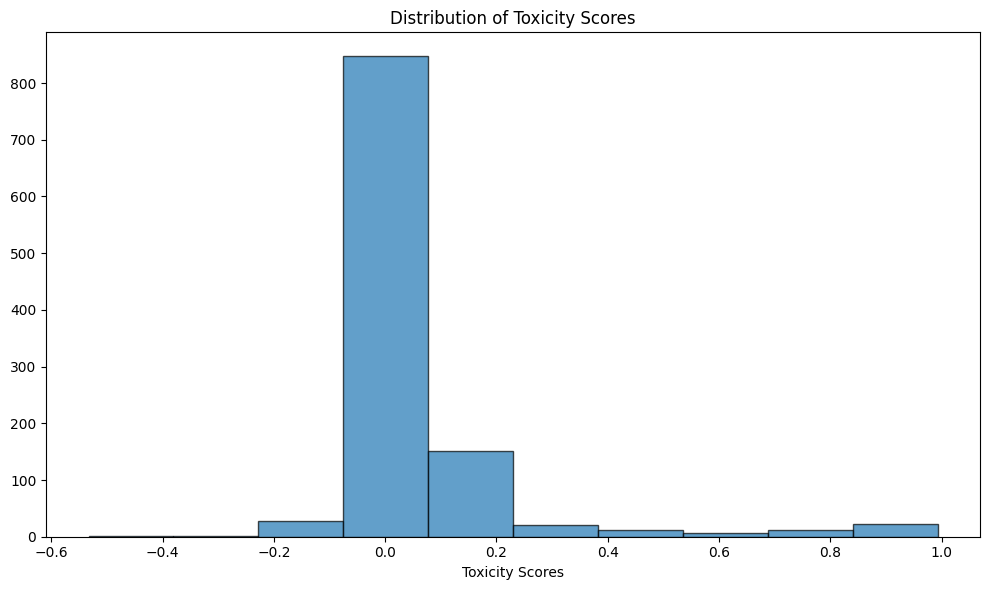

In [29]:
scores = [score for _, score in toxic_word_tuples]

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel("Toxicity Scores")
plt.title("Distribution of Toxicity Scores")
plt.tight_layout()
plt.show()

In [30]:
filtered_words = [word for word, score in toxic_word_tuples if score > 0.1]


In [31]:
len(filtered_words)

190

In [32]:
with open('highlighted_toxic_words_v2.txt', "w") as file:
    for word in filtered_words:
        file.write(word + "\n")

: 